In [82]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as mp
import seaborn as sb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.svm import LinearSVR
from shapely import wkt
from scipy.stats import randint, uniform
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
 

In [83]:
df = pd.read_csv('./Electric_Vehicle_Population_Data.csv')



In [84]:
df.head()

,VIN (1-10),County,City,State,Postal Code,Model Year,Make,Model,Electric Vehicle Type,Clean Alternative Fuel Vehicle (CAFV) Eligibility,Electric Range,Base MSRP,Legislative District,DOL Vehicle ID,Vehicle Location,Electric Utility,2020 Census Tract
0,1N4BZ0CP5G,King,Seattle,WA,98125.0,2016,NISSAN,LEAF,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,84.0,0.0,46.0,349455557,POINT (-122.30253 47.72656),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
1,KNDJX3AEXG,King,Renton,WA,98058.0,2016,KIA,SOUL,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,93.0,31950.0,11.0,210641315,POINT (-122.08747 47.4466),PUGET SOUND ENERGY INC||CITY OF TACOMA - (WA),5.303303e+10
2,5YJ3E1EB2J,King,Seattle,WA,98115.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,43.0,171417494,POINT (-122.31676 47.68156),CITY OF SEATTLE - (WA)|CITY OF TACOMA - (WA),5.303300e+10
3,1C4RJXN64R,Kitsap,Bremerton,WA,98312.0,2024,JEEP,WRANGLER,Plug-in Hybrid Electric Vehicle (PHEV),Not eligible due to low battery range,21.0,0.0,26.0,262542927,POINT (-122.65223 47.57192),PUGET SOUND ENERGY INC,5.303508e+10
4,5YJ3E1EB1J,Thurston,Olympia,WA,98512.0,2018,TESLA,MODEL 3,Battery Electric Vehicle (BEV),Clean Alternative Fuel Vehicle Eligible,215.0,0.0,35.0,110432815,POINT (-122.9131 47.01359),PUGET SOUND ENERGY INC,5.306701e+10


In [85]:
df.shape

(247344, 17)

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247344 entries, 0 to 247343
Data columns (total 17 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   VIN (1-10)                                         247344 non-null  object 
 1   County                                             247340 non-null  object 
 2   City                                               247340 non-null  object 
 3   State                                              247344 non-null  object 
 4   Postal Code                                        247340 non-null  float64
 5   Model Year                                         247344 non-null  int64  
 6   Make                                               247344 non-null  object 
 7   Model                                              247344 non-null  object 
 8   Electric Vehicle Type                              247344 non-null  object

In [87]:
df.columns = df.columns.str.strip()
df.columns

Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Base MSRP', 'Legislative District', 'DOL Vehicle ID',
       'Vehicle Location', 'Electric Utility', '2020 Census Tract'],
      dtype='object')

In [88]:
df.isnull().sum()

VIN (1-10)                                             0
County                                                 4
City                                                   4
State                                                  0
Postal Code                                            4
Model Year                                             0
Make                                                   0
Model                                                  0
Electric Vehicle Type                                  0
Clean Alternative Fuel Vehicle (CAFV) Eligibility      0
Electric Range                                        20
Base MSRP                                             20
Legislative District                                 553
DOL Vehicle ID                                         0
Vehicle Location                                      11
Electric Utility                                       4
2020 Census Tract                                      4
dtype: int64

In [89]:
df.dropna(inplace=True)

In [90]:
df.isnull().sum()

VIN (1-10)                                           0
County                                               0
City                                                 0
State                                                0
Postal Code                                          0
Model Year                                           0
Make                                                 0
Model                                                0
Electric Vehicle Type                                0
Clean Alternative Fuel Vehicle (CAFV) Eligibility    0
Electric Range                                       0
Base MSRP                                            0
Legislative District                                 0
DOL Vehicle ID                                       0
Vehicle Location                                     0
Electric Utility                                     0
2020 Census Tract                                    0
dtype: int64

In [91]:
df.duplicated().sum()

0

### Exploratory Dataanalysis

In [92]:
df['Base MSRP'].value_counts()

Base MSRP
0.0         243559
69900.0       1277
31950.0        355
52900.0        222
32250.0        135
54950.0        124
39995.0        119
59900.0        119
36900.0        105
44100.0         96
64950.0         85
45600.0         78
52650.0         72
34995.0         67
33950.0         66
55700.0         56
36800.0         55
53400.0         37
81100.0         22
110950.0        21
98950.0         16
90700.0         15
75095.0         13
184400.0        13
102000.0         9
89100.0          9
109000.0         7
43700.0          6
91250.0          3
32995.0          2
845000.0         1
Name: count, dtype: int64

In [93]:
df.drop(columns=['Base MSRP'], inplace=True)

In [94]:
 
df = df.dropna(subset=["Vehicle Location", "Electric Range"])
 
df = df[df["Vehicle Location"].str.startswith("POINT")]
df["geometry"] = df["Vehicle Location"].apply(wkt.loads)
 
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
gdf["longitude"] = gdf.geometry.x
gdf["latitude"] = gdf.geometry.y

In [95]:
df.columns

Index(['VIN (1-10)', 'County', 'City', 'State', 'Postal Code', 'Model Year',
       'Make', 'Model', 'Electric Vehicle Type',
       'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Electric Range',
       'Legislative District', 'DOL Vehicle ID', 'Vehicle Location',
       'Electric Utility', '2020 Census Tract', 'geometry'],
      dtype='object')

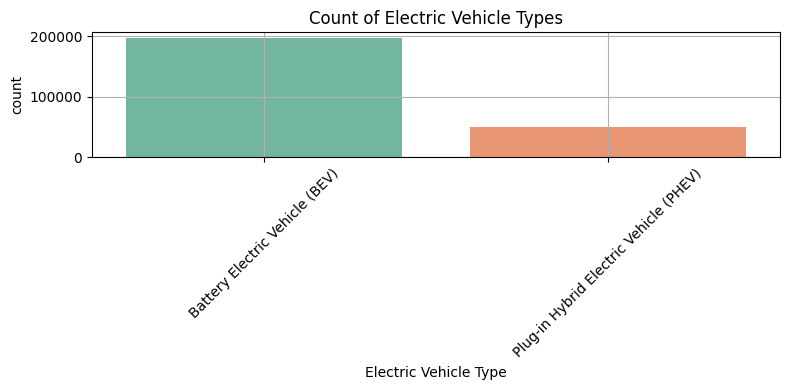

In [96]:
mp.figure(figsize=(8, 4))
sb.countplot(data=df, x='Electric Vehicle Type', palette='Set2')
mp.title('Count of Electric Vehicle Types')
mp.xticks(rotation=45)
mp.grid(True)
mp.tight_layout()
mp.show()

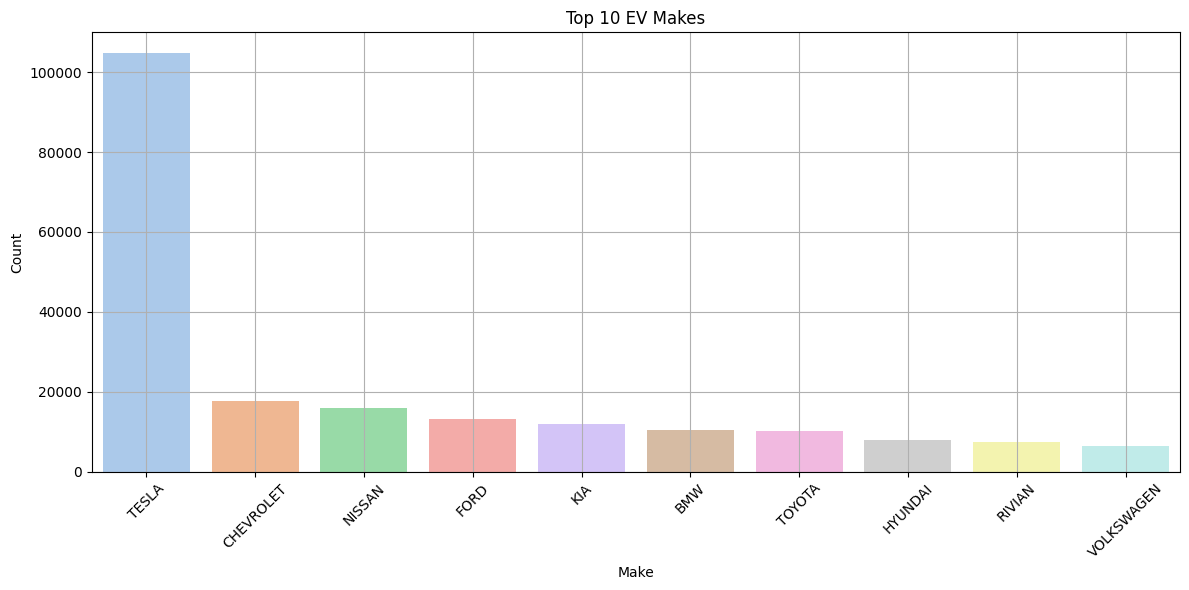

In [97]:
mp.figure(figsize=(12, 6))
sb.countplot(data=df, x='Make', order=df['Make'].value_counts().index[:10], palette='pastel')
mp.title('Top 10 EV Makes')
mp.xlabel('Make')
mp.ylabel('Count')
mp.xticks(rotation=45)
mp.tight_layout()
mp.grid(True)
mp.show()


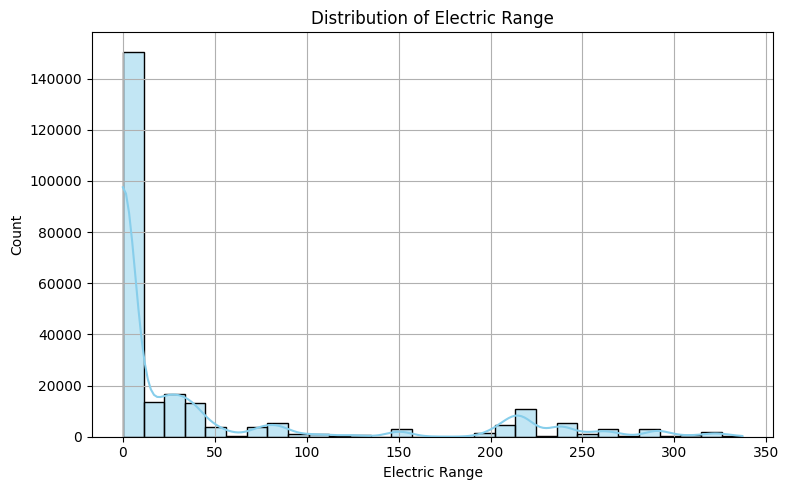

In [98]:
mp.figure(figsize=(8, 5))
sb.histplot(data=df, x='Electric Range', bins=30, kde=True, color='skyblue')
mp.title('Distribution of Electric Range')
mp.grid(True)
mp.tight_layout()
mp.show()


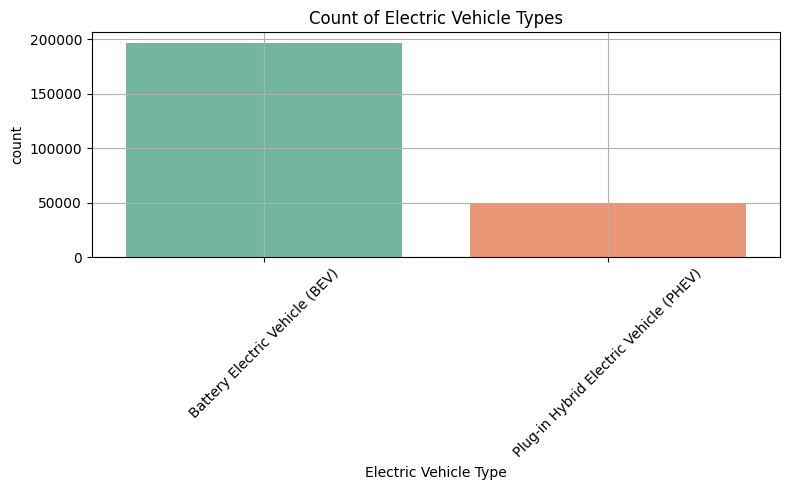

In [99]:
mp.figure(figsize=(8, 5))
sb.countplot(data=df, x='Electric Vehicle Type', palette='Set2')
mp.title("Count of Electric Vehicle Types")
mp.xticks(rotation=45)
mp.grid(True)
mp.tight_layout()
mp.show()

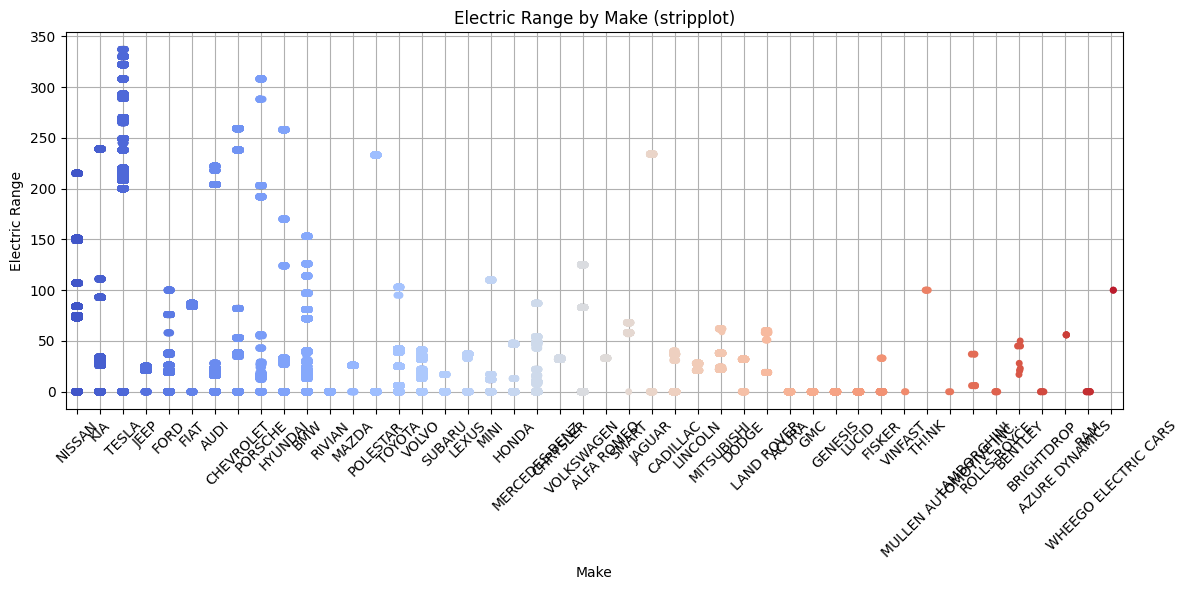

In [100]:
mp.figure(figsize=(12, 6))
sb.stripplot(data=df, x='Make', y='Electric Range', palette='coolwarm', jitter=True)
mp.title('Electric Range by Make (stripplot)')
mp.xticks(rotation=45)
mp.grid(True)
mp.tight_layout()
mp.show()

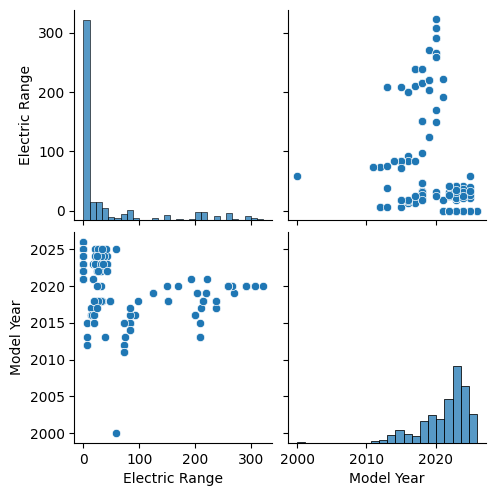

In [101]:
sample_df = df[['Electric Range', 'Model Year']].dropna().sample(300)
sb.pairplot(sample_df)
mp.show()


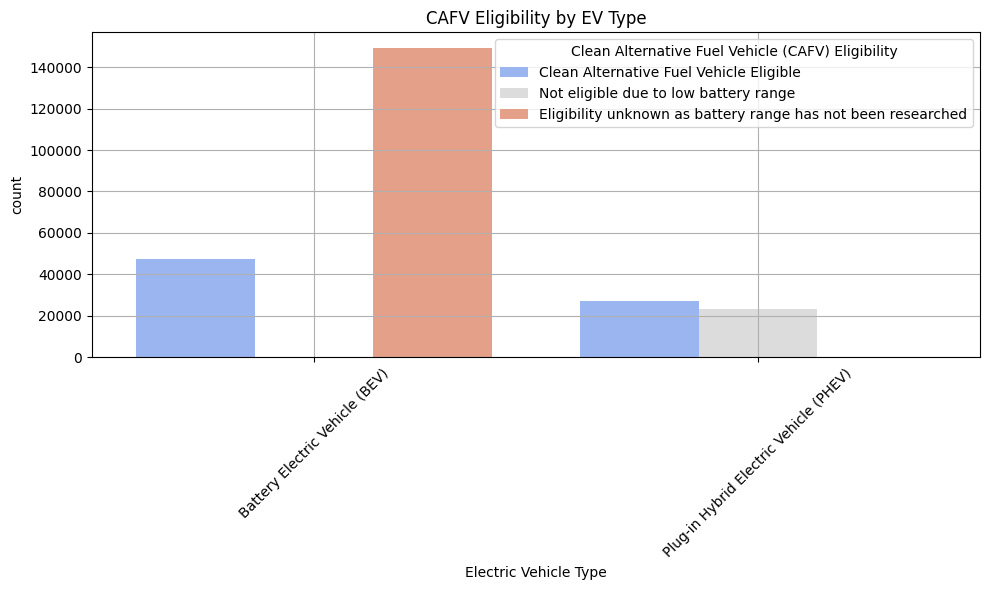

In [102]:
mp.figure(figsize=(10, 6))
sb.countplot(data=df, x='Electric Vehicle Type', hue='Clean Alternative Fuel Vehicle (CAFV) Eligibility', palette='coolwarm')
mp.title("CAFV Eligibility by EV Type")
mp.xticks(rotation=45)
mp.grid(True)
mp.tight_layout()
mp.show()

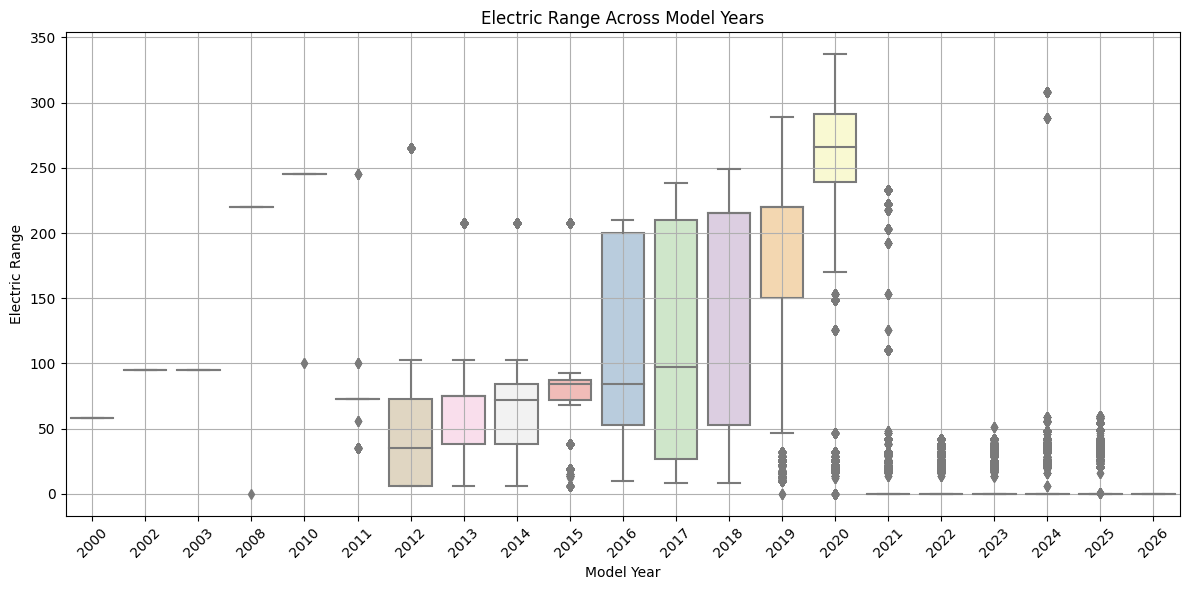

In [103]:
mp.figure(figsize=(12, 6))
sb.boxplot(x='Model Year', y='Electric Range', data=df, palette='Pastel1')
mp.title("Electric Range Across Model Years")
mp.xticks(rotation=45)
mp.grid(True)
mp.tight_layout()
mp.show()


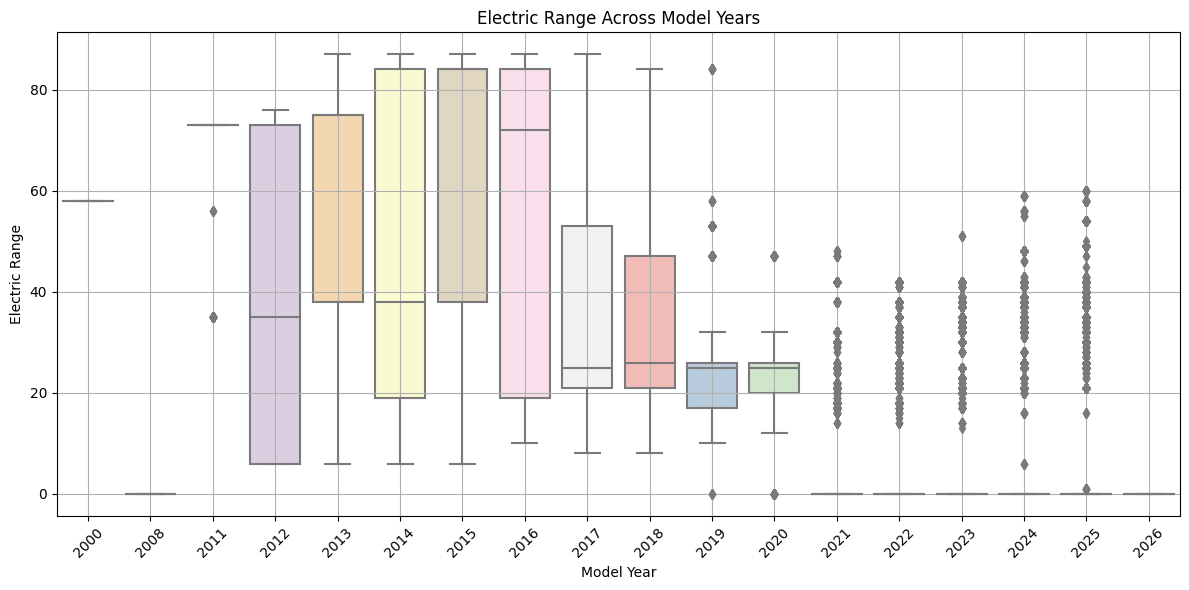

In [104]:
 
 
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return data[(data[column] >= lower) & (data[column] <= upper)]
 
df = remove_outliers_iqr(df, 'Electric Range')

mp.figure(figsize=(12, 6))
sb.boxplot(x='Model Year', y='Electric Range', data=df, palette='Pastel1')
mp.title("Electric Range Across Model Years")
mp.xticks(rotation=45)
mp.grid(True)
mp.tight_layout()
mp.show()


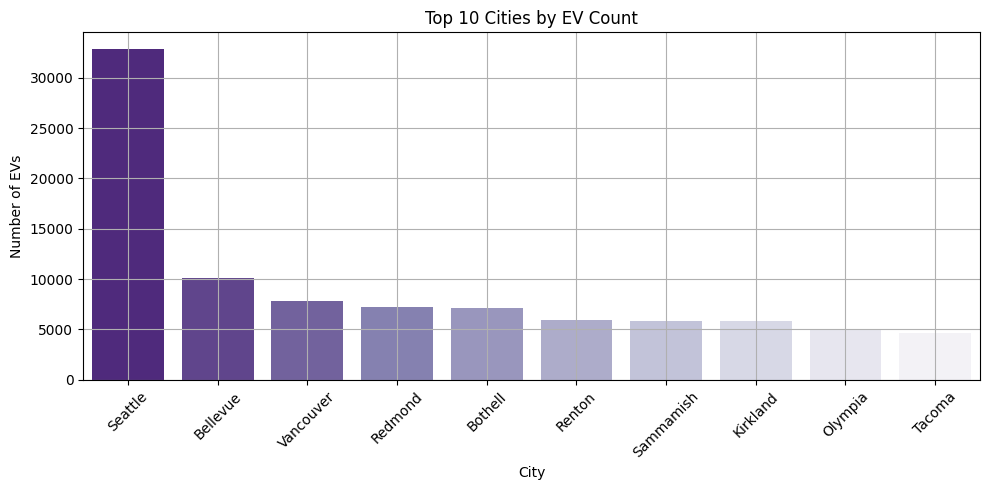

In [105]:
mp.figure(figsize=(10, 5))
top_cities = df['City'].value_counts().nlargest(10)
sb.barplot(x=top_cities.index, y=top_cities.values, palette='Purples_r')
mp.title("Top 10 Cities by EV Count")
mp.ylabel("Number of EVs")
mp.xticks(rotation=45)
mp.grid(True)
mp.tight_layout()
mp.show()


/tmp/ipykernel_526394/2176244250.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  mp.tight_layout()


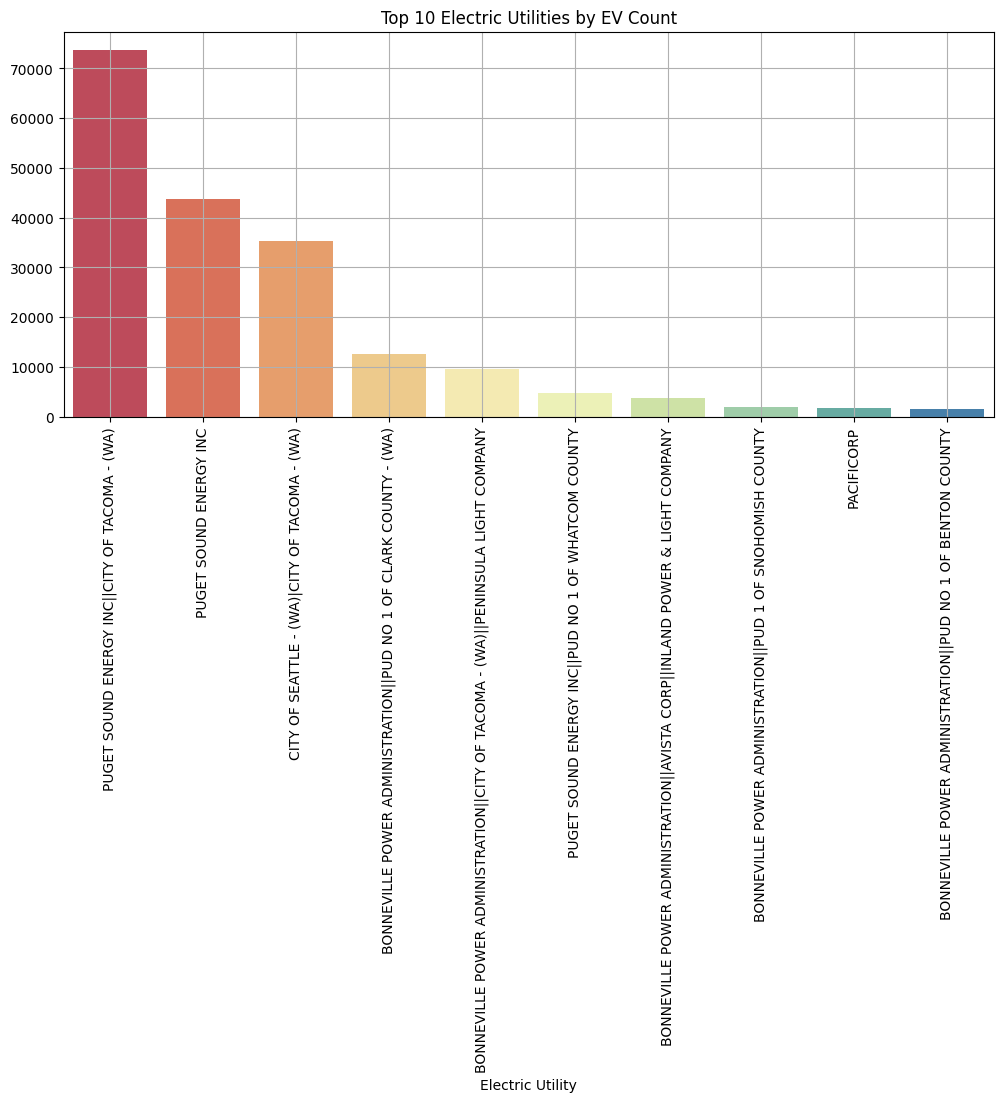

In [106]:
mp.figure(figsize=(12, 5))
top_utils = df['Electric Utility'].value_counts().nlargest(10)
sb.barplot(x=top_utils.index, y=top_utils.values, palette='Spectral')
mp.title("Top 10 Electric Utilities by EV Count")
mp.xticks(rotation=90)
mp.grid(True)
mp.tight_layout()
mp.show()

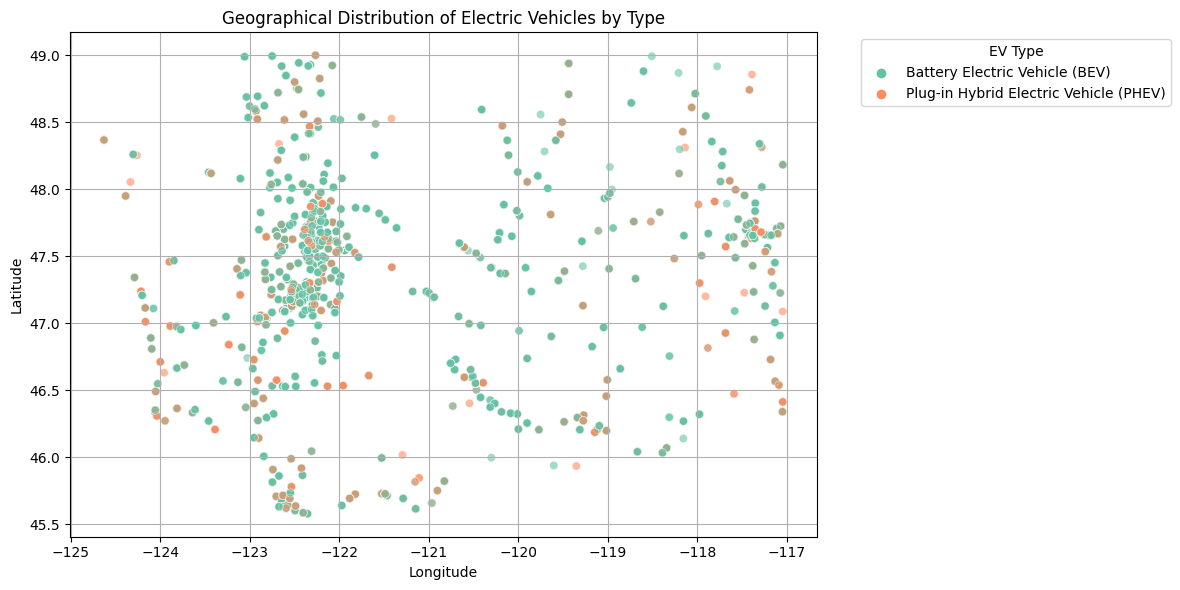

In [107]:
mp.figure(figsize=(12, 6))
sb.scatterplot(data=gdf, x='longitude', y='latitude', hue='Electric Vehicle Type', palette='Set2', alpha=0.6)
mp.title("Geographical Distribution of Electric Vehicles by Type")
mp.xlabel("Longitude")
mp.ylabel("Latitude")
mp.legend(title='EV Type', bbox_to_anchor=(1.05, 1), loc='upper left')
mp.grid(True)
mp.tight_layout()
mp.show()

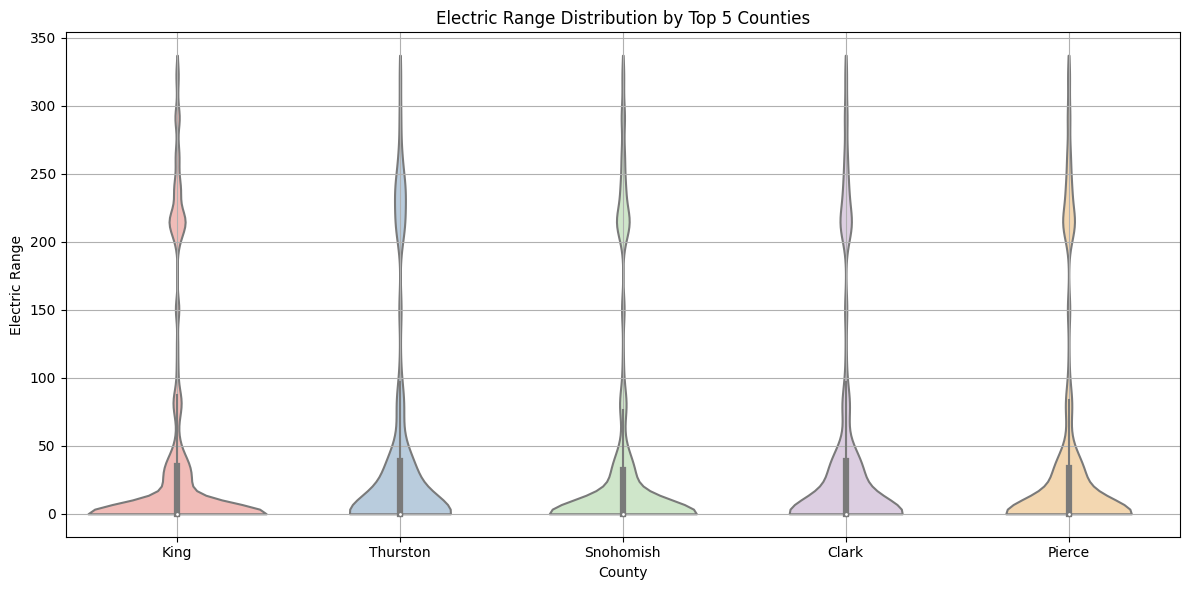

In [108]:
top_counties = gdf['County'].value_counts().nlargest(5).index
filtered_gdf = gdf[gdf['County'].isin(top_counties)]

mp.figure(figsize=(12, 6))
sb.violinplot(data=filtered_gdf, x='County', y='Electric Range', palette='Pastel1', cut=0)
mp.title("Electric Range Distribution by Top 5 Counties")
mp.grid(True)
mp.tight_layout()
mp.show()


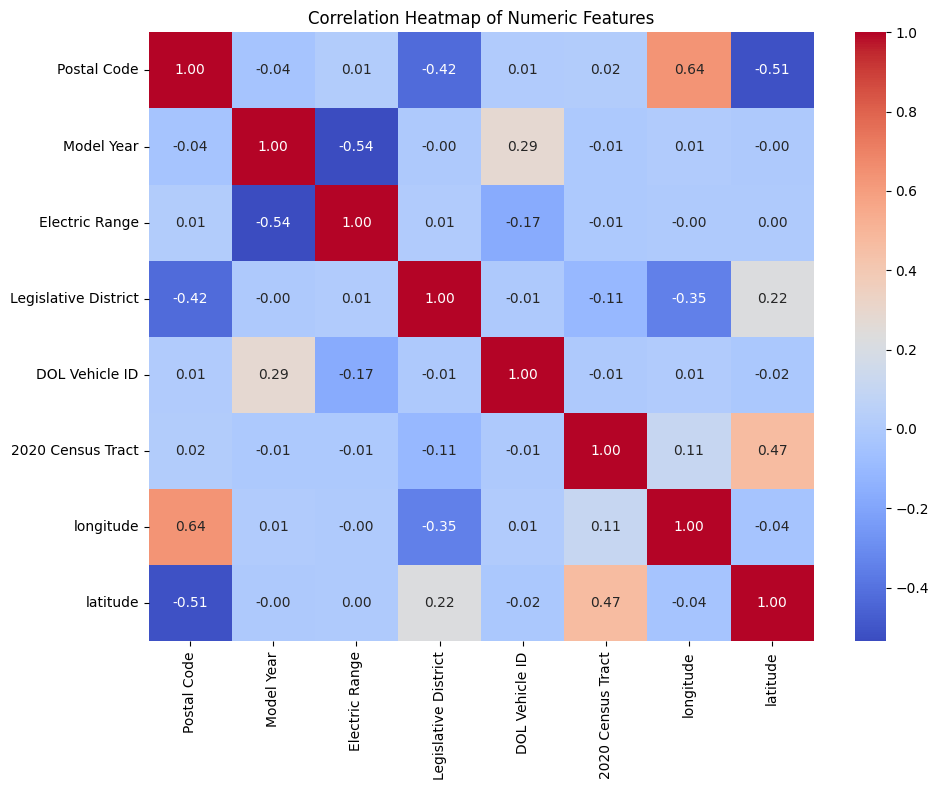

In [109]:
numeric_cols = gdf.select_dtypes(include='number')
mp.figure(figsize=(10, 8))
sb.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt=".2f")
mp.title("Correlation Heatmap of Numeric Features")
mp.tight_layout()
mp.show()


In [110]:
 
categorical_cols = [
    'County', 'City', 'State', 'Make', 'Model',
    'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility',
    'Electric Utility'
]

label_encoders = {}
for col in categorical_cols:
    if col in gdf.columns:
        le = LabelEncoder()
        gdf[col] = le.fit_transform(gdf[col].astype(str))
        label_encoders[col] = le


In [111]:
drop_cols = ['VIN (1-10)', 'DOL Vehicle ID', 'Vehicle Location', 'Base MSRP', '2020 Census Tract', 'geometry']
gdf = gdf.drop(columns=[col for col in drop_cols if col in gdf.columns], errors='ignore')

y = gdf['Electric Range']
X = gdf.drop(columns=['Electric Range'])

 
print("Final feature columns:", X.columns.tolist())

Final feature columns: ['County', 'City', 'State', 'Postal Code', 'Model Year', 'Make', 'Model', 'Electric Vehicle Type', 'Clean Alternative Fuel Vehicle (CAFV) Eligibility', 'Legislative District', 'Electric Utility', 'longitude', 'latitude']


In [112]:
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### LinearRegression

In [113]:
lr_model=LinearRegression()
lr_model.fit(X_train_scaled, y_train)
lr_y_pred = lr_model.predict(X_test_scaled)

In [114]:
results = {}

def evaluate_model(name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R² Score': r2
    }
    
    print(f"{name} Performance:")
    print(f"  - MAE      : {mae:.2f}")
    print(f"  - MSE      : {mse:.2f}")
    print(f"  - RMSE     : {rmse:.2f}")
    print(f"  - R² Score : {r2:.4f}")
 

In [115]:
evaluate_model("Linear Regression", y_test, lr_y_pred)

Linear Regression Performance:
  - MAE      : 40.39
  - MSE      : 3232.54
  - RMSE     : 56.86
  - R² Score : 0.5332


### RandomForestRegressor

In [116]:
rf_model=RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_y_pred = rf_model.predict(X_test_scaled)

In [117]:
evaluate_model("Random Forest", y_test, rf_y_pred)

Random Forest Performance:
  - MAE      : 0.49
  - MSE      : 15.59
  - RMSE     : 3.95
  - R² Score : 0.9977


### XGBoost Regressor

In [118]:
XG_model= XGBRegressor(objective='reg:squarederror', random_state=42)
XG_model.fit(X_train_scaled, y_train)
XG_model_pred = XG_model.predict(X_test_scaled)

In [119]:
evaluate_model("XGBoost", y_test, XG_model_pred)

XGBoost Performance:
  - MAE      : 0.62
  - MSE      : 13.74
  - RMSE     : 3.71
  - R² Score : 0.9980


### LinearSVR_model

In [120]:

X_svr = X_train_scaled[:5000]
y_svr = y_train[:5000]

 
LinearSVR_model = LinearSVR(max_iter=10000, random_state=42)
LinearSVR_model.fit(X_svr, y_svr)

LinearSVR_y_pred = LinearSVR_model.predict(X_test_scaled)


In [121]:
evaluate_model("LinearSVR", y_test, LinearSVR_y_pred)

LinearSVR Performance:
  - MAE      : 34.13
  - MSE      : 4765.94
  - RMSE     : 69.04
  - R² Score : 0.3117


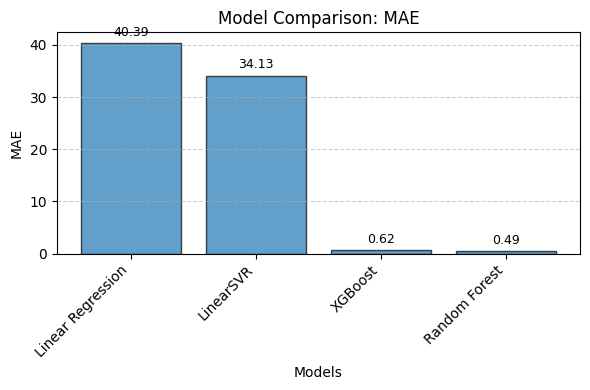

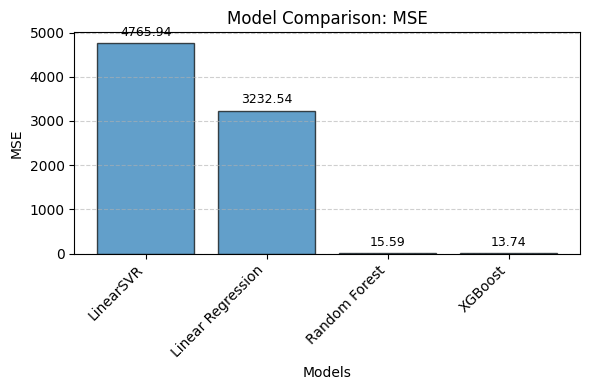

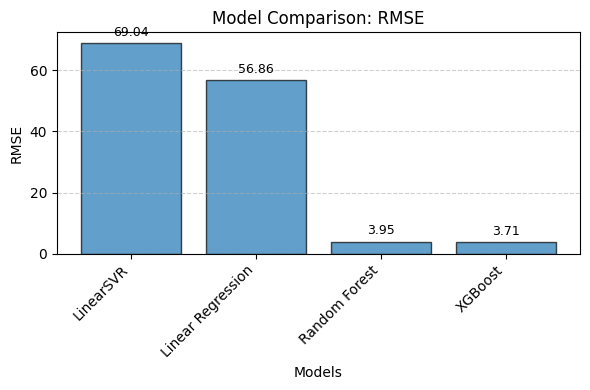

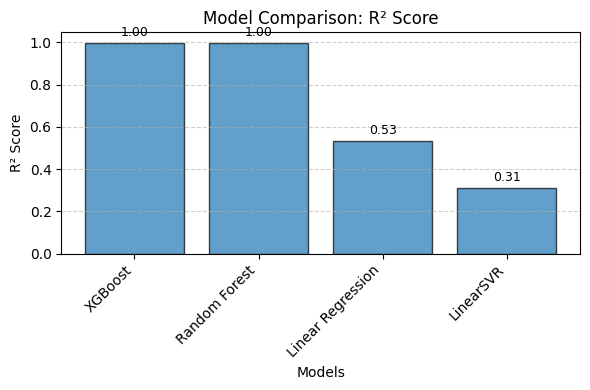

In [122]:
results_df = pd.DataFrame(results).T   
 
for metric in results_df.columns:
    mp.figure(figsize=(6, 4))
    
    data = results_df[metric].sort_values(ascending=False)
    bars = mp.bar(data.index, data.values, edgecolor='black', alpha=0.7)
    
    mp.title(f"Model Comparison: {metric}", fontsize=12)
    mp.ylabel(metric)
    mp.xlabel("Models")
    mp.xticks(rotation=45, ha='right')
    mp.grid(axis='y', linestyle='--', alpha=0.6)
    
    for bar in bars:
        height = bar.get_height()
        mp.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),   
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)
    mp.tight_layout()
    mp.show()

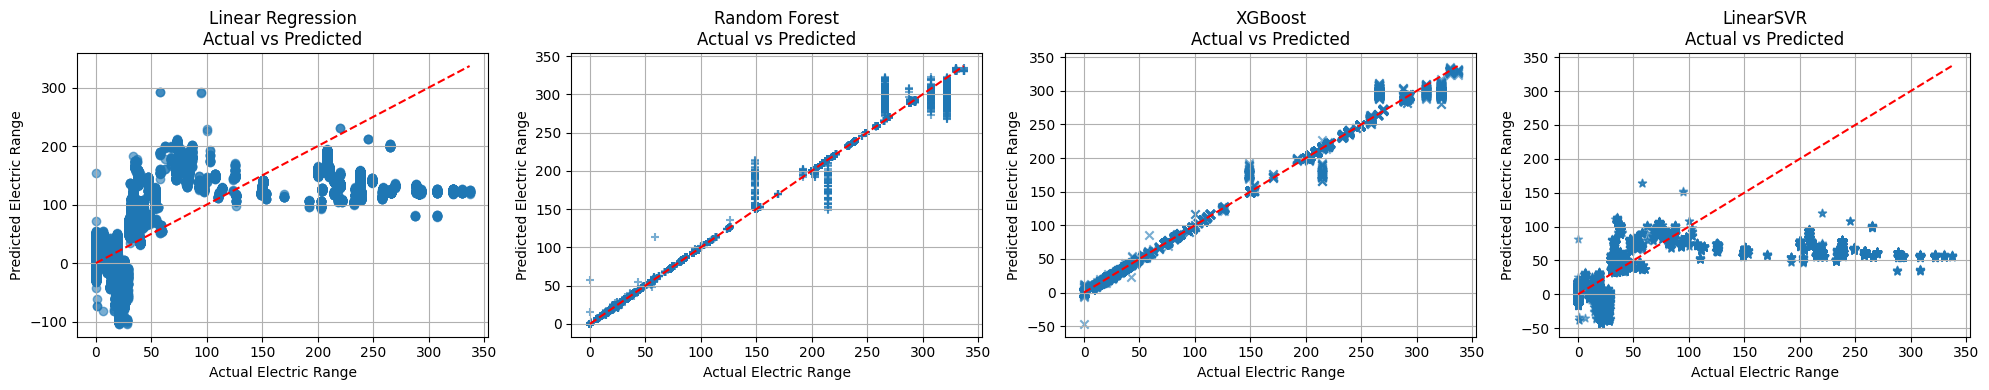

In [123]:
predictions = {
    'Linear Regression': lr_y_pred,
    'Random Forest': rf_y_pred,          
    'XGBoost': XG_model_pred,
    'LinearSVR': LinearSVR_y_pred
}
 
markers = {
    'Linear Regression': 'o',    
    'Random Forest': '+',        
    'XGBoost': 'x',              
    'LinearSVR': '*'             
}
 
mp.figure(figsize=(20, 4))

for i, (name, y_pred) in enumerate(predictions.items(), start=1):
    mp.subplot(1, 4, i)
     
    mp.scatter(y_test, y_pred, alpha=0.6, marker=markers[name])
    
    mp.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
    
    mp.xlabel('Actual Electric Range')
    mp.ylabel('Predicted Electric Range')
    mp.title(f'{name}\nActual vs Predicted')
    mp.grid(True)

mp.tight_layout()
mp.show()


In [124]:
results = {}

def evaluate_model(name, y_test, y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R² Score': r2
    }
    
    print(f" Tuned  {name} Performance:")
    print(f"  - MAE      : {mae:.2f}")
    print(f"  - MSE      : {mse:.2f}")
    print(f"  - RMSE     : {rmse:.2f}")
    print(f"  - R² Score : {r2:.4f}")
 

### Parameter Tuning for RandomForestRegressor

In [125]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
 
base_rf = RandomForestRegressor(random_state=42, max_features=1.0)
rf_param_dist = {
    'n_estimators': randint(100, 500),
    'max_depth': [None] + list(range(10, 51, 10)),
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 6),
    
    'max_features': ['sqrt', 1.0],
    'bootstrap': [True, False]
}

rf_search = RandomizedSearchCV(
    estimator=base_rf,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
rf_search.fit(X_train_scaled, y_train)  

print("Best RF params:", rf_search.best_params_)
best_rf = rf_search.best_estimator_

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best RF params: {'bootstrap': True, 'max_depth': 10, 'max_features': 1.0, 'min_samples_leaf': 4, 'min_samples_split': 3, 'n_estimators': 301}


In [126]:
rf_best_y_pred = best_rf.predict(X_test_scaled)
 
evaluate_model("Random Forest", y_test, rf_best_y_pred)


 Tuned  Random Forest Performance:
  - MAE      : 0.57
  - MSE      : 14.74
  - RMSE     : 3.84
  - R² Score : 0.9979


### Parameter Tuning for XGBoost Regressor

In [127]:
xgb_param_dist = {
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.2),    
    'max_depth': randint(3, 10),           
    'subsample': uniform(0.6, 0.4),         
    'colsample_bytree': uniform(0.6, 0.4),   
    'gamma': uniform(0, 5),                
    'reg_alpha': uniform(0, 1),            
    'reg_lambda': uniform(0, 1)           
}
xgb = XGBRegressor(objective='reg:squarederror', random_state=42, tree_method='hist')
xgb_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=xgb_param_dist,
    n_iter=25,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42,
    pre_dispatch='2*n_jobs'
)
xgb_search.fit(X_train_scaled, y_train)
print("Best XGB params:", xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_


Fitting 3 folds for each of 25 candidates, totalling 75 fits


/home/akhil/anaconda3/envs/project/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best XGB params: {'colsample_bytree': 0.9395655297064336, 'gamma': 3.608647605824366, 'learning_rate': 0.057196983949791155, 'max_depth': 8, 'n_estimators': 152, 'reg_alpha': 0.04043358953843135, 'reg_lambda': 0.7106628896857874, 'subsample': 0.6443563283247326}


In [128]:
y_pred = best_xgb.predict(X_test_scaled)
evaluate_model("XGBoost", y_test, y_pred)


 Tuned  XGBoost Performance:
  - MAE      : 0.58
  - MSE      : 13.78
  - RMSE     : 3.71
  - R² Score : 0.9980


### Parameter Tuning for LinearSVR

In [129]:
svr_param_dist = {
    'C': uniform(0.01, 10),       
    'epsilon': uniform(0.0, 1.0), 
    'loss': ['epsilon_insensitive', 'squared_epsilon_insensitive'],
    'dual': [True]     
}
lsvr = LinearSVR(random_state=42, max_iter=10000)
lsvr_search = RandomizedSearchCV(
    estimator=lsvr,
    param_distributions=svr_param_dist,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)
lsvr_search.fit(X_svr, y_svr)
print("Best LinearSVR params:", lsvr_search.best_params_)
best_lsvr = lsvr_search.best_estimator_


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best LinearSVR params: {'C': 2.3189382562214895, 'dual': True, 'epsilon': 0.24102546602601171, 'loss': 'squared_epsilon_insensitive'}


In [130]:
y_pred = best_lsvr.predict(X_test_scaled)
evaluate_model("LinearSVR", y_test, y_pred)


 Tuned  LinearSVR Performance:
  - MAE      : 40.54
  - MSE      : 3238.35
  - RMSE     : 56.91
  - R² Score : 0.5323


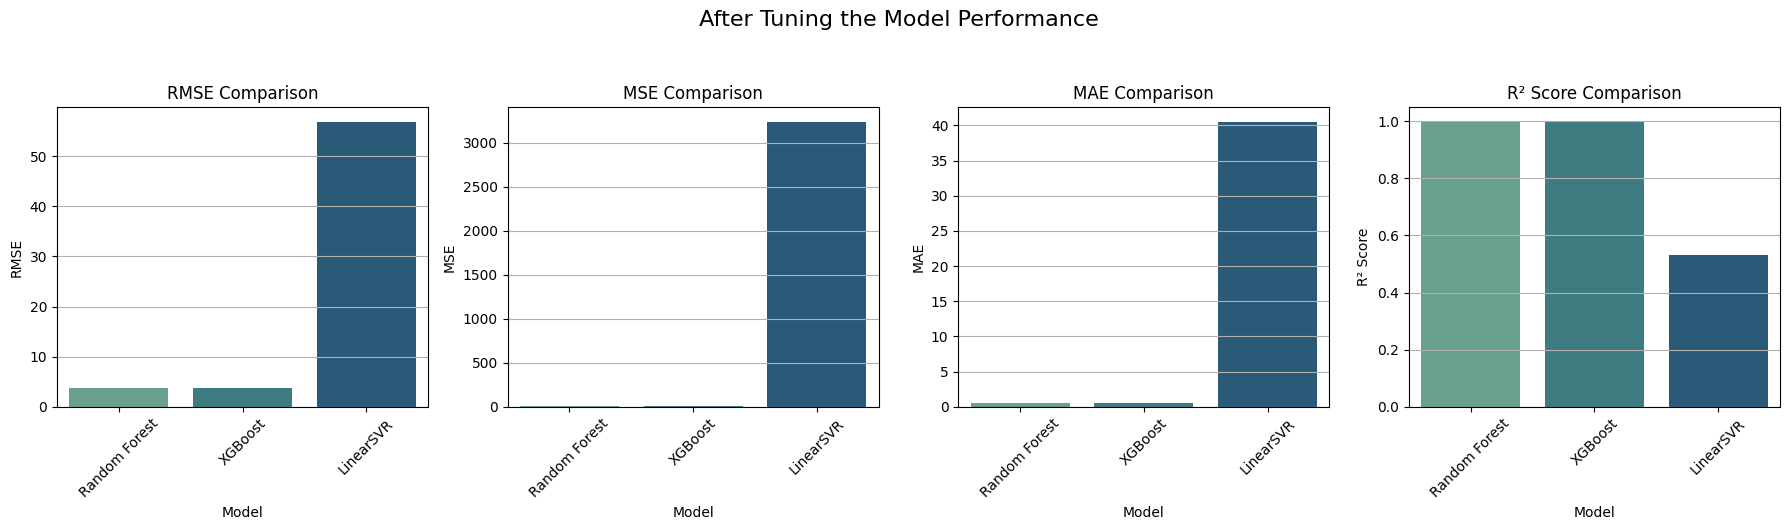

In [131]:
results_df = pd.DataFrame(results)

 
 
mp.figure(figsize=(18, 5))

metrics = ['RMSE', 'MSE','MAE', 'R² Score']

for i, metric in enumerate(metrics):
    mp.subplot(1, 4, i + 1)
    sb.barplot(x=results_df.columns, y=results_df.loc[metric], palette='crest')
    mp.title(f'{metric} Comparison')
    mp.ylabel(metric)
    mp.xlabel('Model')
    mp.xticks(rotation=45)
    mp.grid(True, axis='y')

mp.suptitle(" After Tuning the Model Performance", fontsize=16, y=1.05)
mp.tight_layout()
mp.show()


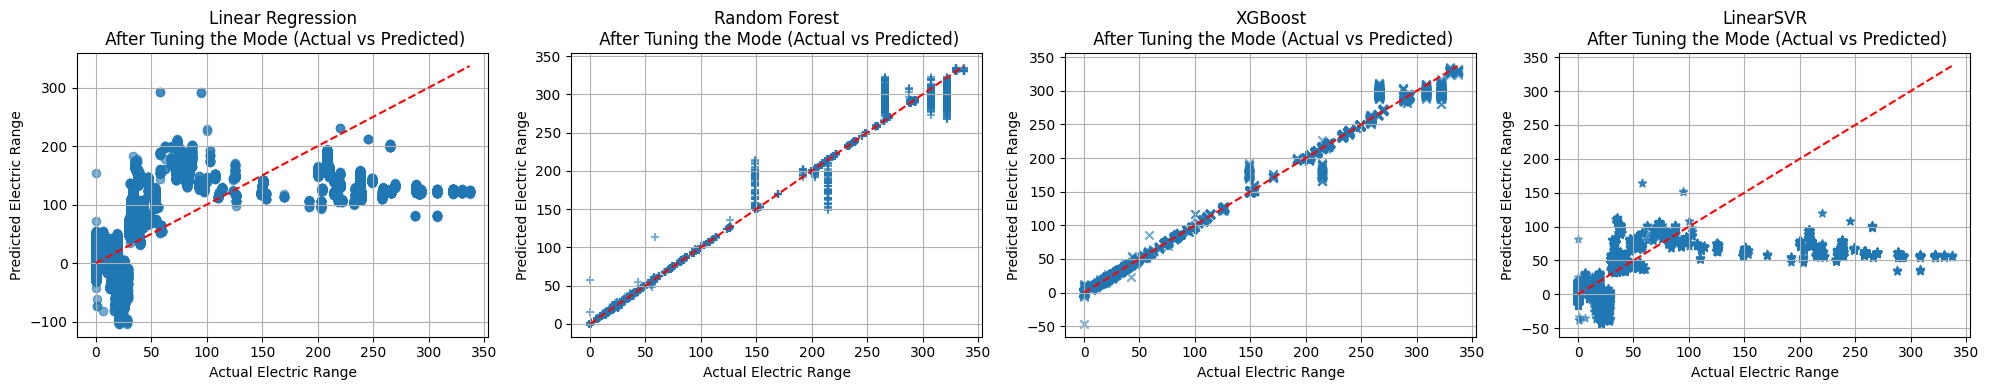

In [132]:
predictions = {
    'Linear Regression': lr_y_pred,
    'Random Forest': rf_y_pred,          
    'XGBoost': XG_model_pred,
    'LinearSVR': LinearSVR_y_pred
}
 
markers = {
    'Linear Regression': 'o',    
    'Random Forest': '+',        
    'XGBoost': 'x',              
    'LinearSVR': '*'             
}
 
mp.figure(figsize=(20, 4))

for i, (name, y_pred) in enumerate(predictions.items(), start=1):
    mp.subplot(1, 4, i)
     
    mp.scatter(y_test, y_pred, alpha=0.6, marker=markers[name])
    
    mp.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5)
    
    mp.xlabel('Actual Electric Range')
    mp.ylabel('Predicted Electric Range')
    mp.title(f'{name}\n After Tuning the Mode (Actual vs Predicted)')
    mp.grid(True)

mp.tight_layout()
mp.show()


In [133]:
scores = cross_val_score(RandomForestRegressor(n_estimators=100, random_state=42),
                         X_train_scaled, y_train, cv=5, scoring='r2',n_jobs=2 )
print("RF CV R²:", np.round(scores, 4), "Mean:", scores.mean())

scores = cross_val_score(XGBRegressor(objective='reg:squarederror', random_state=42),
                         X_train_scaled, y_train, cv=5, scoring='r2',n_jobs=2 )
print("XGB CV R²:", np.round(scores, 4), "Mean:", scores.mean())

RF CV R²: [0.9978 0.9978 0.9977 0.9978 0.9979] Mean: 0.9978020884069683
XGB CV R²: [0.9981 0.9981 0.9981 0.998  0.9982] Mean: 0.9981056804818917
